# Setup

In [1]:
from setup import *

In [2]:
from pqdm.processes import pqdm

In [3]:
aus = City('Austin, TX')
cam = City('Cambridge, MA')
tor = City('City of Toronto', 'Toronto')

In [4]:
cities = [cam, tor, aus]

In [5]:
colors = dict(current='#DB7F57', sidewalks='#61C314', crosswalks='#12BFF6', both='#BF54F2')

In [6]:
od_fname = 'sample_OD_n1000000_seed1234_d800m'

---
# Create pednet variants

In [7]:
%%time
# t = 22s
pns = [Pednet(*params, od_fname) for params in tqdm([
    # Cambridge
    (cam, 'exists', 'current'),
    (cam, 'exists or is_xwalk', 'crosswalks'),
    # Austin
    (aus, 'exists', 'current'),
    (aus, 'exists or ~is_xwalk', 'sidewalks'),
    (aus, 'exists or is_xwalk', 'crosswalks'),
    (aus, None, 'both'),
    # Toronto
    (tor, 'exists', 'current'),
    (tor, 'exists or ~is_xwalk', 'sidewalks'),
    (tor, 'exists or is_xwalk', 'crosswalks'),
    (tor, None, 'both'),
])]
for c in cities:
    c.pn = {pn.name: pn for pn in pns if pn.city == c}

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 15.6 s, sys: 1.23 s, total: 16.8 s
Wall time: 16.8 s


## Load saved edges

In [8]:
%time for pn in pns: pn.E = pd.read_pickle(pn.city.root + f'edges/{pn.name}.pickle') # t = 4s

CPU times: user 1.62 s, sys: 202 ms, total: 1.83 s
Wall time: 1.83 s


## Load paths

In [9]:
%%time
# t = 46s
for c in tqdm(cities):
    c.sp = {name: pd.read_pickle(glob(c.root + f'paths/{name}_*od.pickle')[0]) for name, pn in c.pn.items()}

  0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 23.8 s, sys: 3.57 s, total: 27.4 s
Wall time: 27.4 s


# Benefit-cost curves

## No. of links vs benefit

In [10]:
def get_ntrips(pn):
    od = (pn.od.groupby(['vid_o','vid_d'])['n_ods'].sum().reset_index()
          .merge(pn.V['cid'].rename('cid_o'), left_on='vid_o', right_index=True)
          .merge(pn.V['cid'].rename('cid_d'), left_on='vid_d', right_index=True))
    n_trips = od.query('cid_o == cid_d')['n_ods'].sum()
    return n_trips
    
# get_ntrips(cam.pn['current'])

In [11]:
def get_nlinks_vs_ntrips(city, kind, interval=1, od_fname=od_fname, save=True):
    min_pn, max_pn = city.pn['current'], city.pn[kind]
    new_E = (max_pn.E.pipe(lambda df: df[~df['id'].isin(min_pn.E['id'])])
             .sort_values('pedscore', ascending=False))
    min_trips = get_ntrips(min_pn)
    max_trips = get_ntrips(max_pn)
    max_links = max_pn.E.shape[0] - min_pn.E.shape[0]
    res = [dict(n_links=0, pct_links=0, pct_new_trips=0, length=0)]
    for n in tqdm(np.arange(0, new_E.shape[0]+1, interval)[1:]):
        extra_len = new_E[:n]['len'].sum()
        E = pd.concat([min_pn.E, new_E.iloc[:n]])
        pn = Pednet(city, name=f'top_{n}', od_fname=od_fname, E=E)
        pct_new_trips = 100 * (get_ntrips(pn) - min_trips) / (max_trips - min_trips)
        res.append(dict(n_links=n, pct_links=100*n/max_links,
                        pct_new_trips=pct_new_trips, length=extra_len))
    res = Pdf(res)
    if save:
        outdir = U.mkdir(city.root + f'top_pn_paths/{kind}/')
        res.to_pickle(outdir + f'ntrips__{interval}.pickle')
    
# %time x = get_nlinks_vs_ntrips(cam, 'crosswalks', 20); x

In [12]:
# %time get_nlinks_vs_ntrips(cam, 'crosswalks', 20) #  t = 52s

In [13]:
# # total time: 10min 20s
# %time get_nlinks_vs_ntrips(tor, 'crosswalks', 200) #  t = 36s
# %time get_nlinks_vs_ntrips(tor, 'sidewalks', 200) #  t = 4min 35s
# %time get_nlinks_vs_ntrips(tor, 'both', 200) #  t = 5min 9s

In [14]:
# # total time: 14min 44s
# %time get_nlinks_vs_ntrips(aus, 'crosswalks', 500) #  t = 3min 27s
# %time get_nlinks_vs_ntrips(aus, 'sidewalks', 500) #  t = 3min 47s
# %time get_nlinks_vs_ntrips(aus, 'both', 500) #  t = 7min 30s

## Distance change

In [15]:
class Pednet2:
    def __init__(self, city, E):
        V0 = city.load('full_pednet_nodes')
        V = V0.loc[list(set(E['src_vid']) | set(E['trg_vid']))].sort_index()
        G = Graph(); G.add_vertices(V.shape[0], {'vid': V.index})
        vid2idx = pd.Series(range(V.shape[0]), index=V.index)
        end_pts = list(zip(vid2idx.loc[E['src_vid']], vid2idx.loc[E['trg_vid']]))
        G.add_edges(end_pts, {k: list(v.values()) for k, v in 
                              E.reset_index().to_dict().items() if k != 'geometry'})
        self.V, self.E, self.G, self.vid2idx = V, E, G, vid2idx
        
    def get_sp(self, o, d):
        oid, did = self.vid2idx.loc[o], self.vid2idx.loc[d]
        sp = self.G.get_shortest_paths(oid, did, 'len', output='epath')[0]
        edges = [e['id'] for i, e in enumerate(self.G.es) if i in sp]
        return {'vid_o': o, 'vid_d': d, 'edges': edges,
                'd_V2V': self.E.loc[edges]['len'].sum()}

In [16]:
def get_pn_dist_change(city, kind, interval, n_jobs=50, save=True):
    # the big two -- least and most connected pednets
    pn_min, pn_max = city.pn['current'], city.pn[kind]
    E_min = pn_min.E.set_index('id')
    E = E_max = pn_max.E.set_index('id')
    # identify the treatment edges (that keep on removing from the graph)
    E_treat = E[~E.index.isin(E_min.index)].sort_values('pedscore')
    # shortest paths of the least and most connected graph
    sp_min, sp_max = city.sp['current'], city.sp[kind]
    # paths in most connected graph between OD pairs common in all pednets
    sp = sp_max.merge(sp_min[['vid_o','vid_d']]).set_index(['vid_o','vid_d'])
    # for each iteration of removing some links
    n_iter = int(np.ceil(E_treat.shape[0] / interval))
    for n in tqdm(range(n_iter)):
        print(f'Iteration={n+1}')
        # remove edges in this iteration
        E_removed = E_treat.iloc[n*interval: (n+1)*interval]
        E = E.loc[~E.index.isin(E_removed.index)]
        # identify the possibly affected OD pairs, i.e.,
        # those whose current shortest path includes the edges
        sp_edges = sp['edges'].explode().rename('id').reset_index()
        od = sp_edges.merge(E_removed.reset_index()['id'])
        od = list(set(zip(od['vid_o'], od['vid_d'])))
        if len(od) == 0:
            continue
        # create the updated pednet graph
        global pn, sp_func
        pn = Pednet2(city, E)
        # define the global function for shortest path-finding to be run in parallel
        exec('def sp_func(o, d): return pn.get_sp(o, d)', globals())
        # compute the shortest paths for these OD pairs
        sp_new = Pdf(pqdm(od, sp_func, n_jobs=n_jobs, total=len(od), argument_type='args'))
        if sp_new.shape == (0, 0): continue
        # update the paths table with the affected OD pairs & their paths
        sp_new = sp_new.set_index(['vid_o','vid_d'])
        with pd.option_context('mode.chained_assignment', None):
            sp['changed'], sp_new['changed'] = False, True
            sp.loc[sp_new.index, :] = sp_new
        # save the modified OD pairs & paths
        if save:
            outdir = U.mkdir(city.root + f'paths/current_vs_{kind}/')
            fname = f'{n*interval}-{(n+1)*interval}.pickle'
            sp.drop(columns='edges').to_pickle(outdir + fname)
    
# %time x = get_pn_dist_change(cam, 'crosswalks', 100); x # t = 3min 57s
# %time x = get_pn_dist_change(tor, 'crosswalks', 500); x # t = 5min 39s
# %time x = get_pn_dist_change(tor, 'sidewalks', 1000); x # t = ???
# %time x = get_pn_dist_change(tor, 'both', 1000); x # t = ~10min
# %time x = get_pn_dist_change(aus, 'sidewalks', 2000); x # t = 1h 24min 28s
# %time x = get_pn_dist_change(aus, 'crosswalks', 2000); x # t = ~10min
# %time x = get_pn_dist_change(aus, 'both', 2000); x # ???

### Check mean distance change

In [17]:
def check_mean_dist_change(city, kind):
    base = city.sp[kind].merge(city.sp['current'][['vid_o','vid_d']])
    res = [{'n_links': 0, 'd_mean': base['d_V2V'].mean()}]
    for f in glob(city.root + f'paths/current_vs_{kind}/*.pickle'):
        n = int(f.split('/')[-1].split('.')[0].split('-')[1])
        df = pd.read_pickle(f)
        res.append({'n_links': n, 'd_mean': df['d_V2V'].mean()})
    res = Pdf(res)
    res.n_links = res.n_links.max() - res.n_links
    res['delta_mean'] = (1 - U.normalize(res.d_mean)) * 100
    return res

for c in cities:
    c.current_vs = {kind: check_mean_dist_change(c, kind) for kind in 
                    [x.split('_')[-1] for x in glob(c.root + 'paths/current_vs_*')]}

## Visualize

CPU times: user 5.11 s, sys: 840 ms, total: 5.95 s
Wall time: 6.8 s


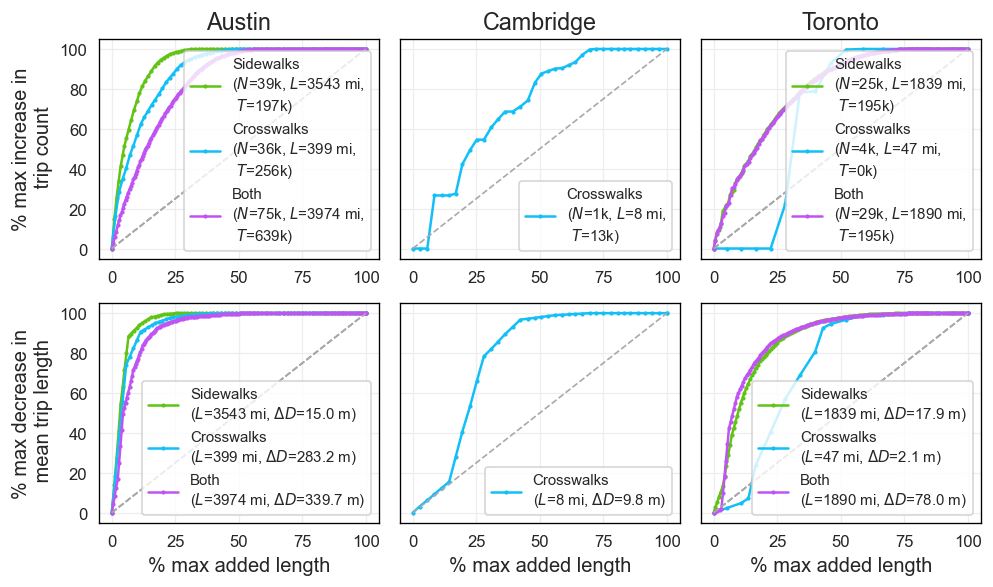

In [18]:
def plot_benefit_cost_curve(cities):
    fig, ax = plt.subplots(2, len(cities), figsize=(2.8*len(cities), 5), dpi=120, sharey=True)
    for j, city in enumerate(cities):
        ax0, ax1 = ax[0, j], ax[1, j]
        ax0 = U.plot(ax0, title=city.name, gridcolor='#eee', xlab='',
                     ylab='% max increase in\n trip count' if j == 0 else '')
        ax1 = U.plot(ax1, gridcolor='#eee', xlab='% max added length',
                     ylab='% max decrease in\n mean trip length' if j == 0 else '')
        for path in glob(city.root + 'top_pn_paths/**/ntrips_*.pickle'):
            kind = path.split('/')[-2]
            df = pd.read_pickle(path)
            min_pn, max_pn = city.pn['current'], city.pn[kind]
            max_trips = get_ntrips(max_pn) - get_ntrips(min_pn)
            max_links = max_pn.E.shape[0] - min_pn.E.shape[0]
            ax0.plot(100 * df['length'] / df['length'].max(), df['pct_new_trips'],
                     color=colors[kind], marker='.', markersize=3,
                     label='%s\n($N$=%.0fk, $L$=%.0f mi,\n $T$=%.0fk)' % 
                     (kind.title(), max_links/1000, df['length'].max() * U.M2MI, max_trips/1000))
            vs = city.current_vs[kind]
            df = (df.merge(vs, how='outer', on='n_links')
                  .set_index('n_links').sort_index().interpolate())
            max_diff = df['d_mean'].max() - df['d_mean'].min()
            ax1.plot(100 * df['length'] / df['length'].max(), df['delta_mean'],
                     color=colors[kind], marker='.', markersize=3,
                     label='%s\n($L$=%.0f mi, $\Delta D$=%.1f m)' % 
                     (kind.title(), df['length'].max() * U.M2MI, max_diff))
            for x in [ax0, ax1]:
                x.plot([0, 100], [0, 100], ls='--', color='darkgrey', lw=1)
                x.legend(loc='lower right', prop={'size': 9})
                for k in ['left','top','right','bottom']:
                    x.spines[k].set_color('k')
    plt.tight_layout()

%time plot_benefit_cost_curve([aus, cam, tor]) # t = 5s
P.imsave('Cost benefit curves')